In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
from sae_lens import SAE
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens import HookedTransformer
from functools import partial
import string
import bitsandbytes
from datasets import load_dataset
from tqdm import tqdm
import numpy as np
from scipy.stats import trim_mean
from torch.utils.data import DataLoader, Dataset
import gc
import time
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [24]:
import sys
sys.path.append("../src/")
from get_reasoning_feats import IndexedPromptDataset, collate_tokenized 
from prompt import format_prompt_aqua

In [3]:
from huggingface_hub import login
login(token="REDACTED")

In [4]:
# torch.cuda.empty_cache()   
# gc.collect()

In [5]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",  
    bnb_4bit_compute_dtype=torch.float16,
    llm_int8_enable_fp32_cpu_offload=True
)

In [6]:
device = utils.get_device()
model_name = 'deepseek-ai/DeepSeek-R1-Distill-Llama-8B'
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:35<00:00, 17.56s/it]


In [7]:
model.eval()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((409

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [9]:
release = "llama_scope_r1_distill"
sae_id = "l25r_400m_slimpajama_400m_openr1_math"
sae, cfg_dict, sparsity = SAE.from_pretrained_with_cfg_and_sparsity(release, sae_id)
sae = sae.to(device)

In [10]:
aqua_ds = load_dataset('aqua_rat', 'raw', split='test')

Generating validation split: 100%|██████████| 254/254 [00:00<00:00, 77711.96 examples/s]


In [11]:
with open('../data/query_list.pkl', 'rb') as f:
    questions = pickle.load(f)

In [12]:
with open('../data/preds_list.pkl', 'rb') as f:
    preds = pickle.load(f)

In [13]:
with open('../data/cot_list.pkl', 'rb') as f:
    cots = pickle.load(f)

In [14]:
with open('../data/query_feats.pkl', 'rb') as f:
    query_feats = pickle.load(f)

In [15]:
with open('../data/cot_feats.pkl', 'rb') as f:
    cot_feats = pickle.load(f)

In [16]:
with open('../data/preds_feats.pkl', 'rb') as f:
    preds_feats = pickle.load(f)

In [18]:
def bin_token_activations_batch(activation_tensor, attention_mask, num_bins=20):
    
    B, T = activation_tensor.shape
    binned = torch.zeros(B, num_bins)
    counts = torch.zeros(B, num_bins)

    for b in range(B):

        valid_indices = attention_mask[b].nonzero(as_tuple=True)[0]
        n_valid = len(valid_indices)

        bin_idx = torch.linspace(0, num_bins, steps=n_valid, dtype=torch.long)
        bin_idx = torch.clamp(bin_idx, max=num_bins - 1)

        for i, token_pos in enumerate(valid_indices):
            idx = bin_idx[i].item()
            binned[b, idx] += activation_tensor[b, token_pos]
            counts[b, idx] += 1

    counts = torch.clamp(counts, min=1)
    return binned / counts

In [19]:
def get_sae_acts(model, sae, input_batch, layer, agg='mean'):

    activation_dict = {}

    def hook_fn(module, input, output):
        activation_dict["hidden"] = output

    hook = model.model.layers[layer].register_forward_hook(hook_fn)

    model.eval()

    with torch.no_grad():
        _ = model(**input_batch)

    hook.remove()

    hidden_states = activation_dict['hidden']
    raw_feats = sae.encode(hidden_states)

    if agg == 'mean':
        mask = input_batch['attention_mask'].unsqueeze(-1)  
        masked_feats = raw_feats * mask                     
        lengths = mask.sum(dim=1).clamp(min=1)            
        result = masked_feats.sum(dim=1) / lengths 
    elif agg == 'last':
        last_token_idxs = input_batch['attention_mask'].sum(dim=1) - 1  
        batch_indices = torch.arange(raw_feats.size(0), device=raw_feats.device)
        result = raw_feats[batch_indices, last_token_idxs]  
    elif agg == 'none':
        mask = input_batch['attention_mask'].unsqueeze(-1)  
        result = raw_feats * mask   

    del hidden_states, raw_feats

    return result

In [20]:
def get_binned_acts_batch(dataloader, model, sae, sae_layer, feature):
    
    tensor_list = []

    with torch.no_grad():
        for batch_inputs in tqdm(dataloader):
            batch_inputs = {k: v.to(model.device) for k, v in batch_inputs.items()}
            attention_mask = batch_inputs['attention_mask'].cpu()

            result = get_sae_acts(model, sae, batch_inputs, sae_layer, agg='none')  
            feature_acts = result[:, :, feature].cpu()  

            binned_batch = bin_token_activations_batch(feature_acts, attention_mask)
            tensor_list.append(binned_batch)
            
    # Clear memory
    del batch_inputs, result, feature_acts, attention_mask
    torch.cuda.empty_cache()
    gc.collect()

    return torch.cat(tensor_list, dim=0)

In [21]:
query_feats

[14012, 6688, 3094, 31076, 4923, 22315, 15155, 6396, 30022, 17135]

In [25]:
queries = [format_prompt_aqua(i, reasoning=False, include_options=False) for i in aqua_ds]

In [26]:
query_tokenized = tokenizer(queries, return_tensors='pt', padding=True, truncation=True)
query_collate_fn = partial(collate_tokenized, tokenized=query_tokenized)
dataset = IndexedPromptDataset(len(questions))
dataloader = DataLoader(dataset, batch_size=8, collate_fn=query_collate_fn)

In [31]:
query_result = get_binned_acts_batch(dataloader, model, sae, 25, 14012) 

100%|██████████| 32/32 [00:09<00:00,  3.29it/s]


In [32]:
query_result.mean(axis=0)

tensor([2.5607, 3.5547, 1.6256, 0.5241, 0.1733, 0.1261, 0.0710, 0.0446, 0.0157,
        0.0137, 0.0269, 0.0196, 0.0088, 0.0166, 0.0122, 0.0371, 0.0159, 0.0566,
        0.2834, 1.7413])

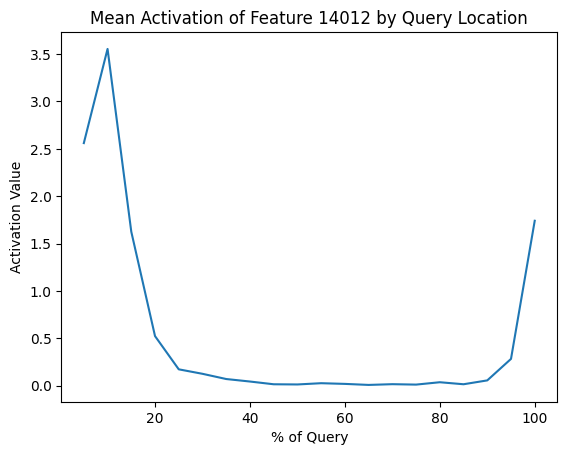

In [34]:
x = np.linspace(5, 100, 20)
y = query_result.mean(axis=0).detach()
plt.plot(x, y)
plt.ylabel("Activation Value")
plt.xlabel("% of Query")
plt.title("Mean Activation of Feature 14012 by Query Location")
# plt.savefig("query_14012.png", dpi=300);

In [36]:
preds_feats

[10527, 12520, 5333, 26077, 2184, 5911, 29395, 29825, 11762, 30538]

In [37]:
cot_tokenized = tokenizer(cots, return_tensors='pt', padding=True, truncation=True)
cot_collate_fn = partial(collate_tokenized, tokenized=cot_tokenized)
dataset = IndexedPromptDataset(len(cots))
dataloader = DataLoader(dataset, batch_size=8, collate_fn=cot_collate_fn)

In [38]:
cot_result = get_binned_acts_batch(dataloader, model, sae, 25, 10527) 

100%|██████████| 32/32 [00:45<00:00,  1.41s/it]


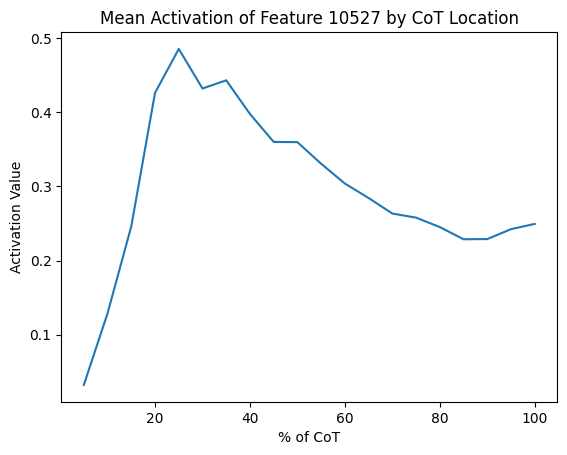

In [40]:
x = np.linspace(5, 100, 20)
y = cot_result.mean(axis=0).detach()
plt.plot(x, y)
plt.ylabel("Activation Value")
plt.xlabel("% of CoT")
plt.title("Mean Activation of Feature 10527 by CoT Location")
# plt.savefig("cot_10527.png", dpi=300);